In [10]:
import os
import pandas as pd

import os
import pandas as pd

# datahub path
if os.path.exists("/uss/hdsi-prismdata/q1-ucsd-inflows.pqt"):
    inflows_path = "/uss/hdsi-prismdata/q1-ucsd-inflows.pqt"
    outflows_path = "/uss/hdsi-prismdata/q1-ucsd-outflows.pqt"
    
# local path
else:
    inflows_path  = r"C:\Users\kangy\dsc180a-prism-data\data\q1-ucsd-inflows.parquet"
    outflows_path = r"C:\Users\kangy\dsc180a-prism-data\data\q1-ucsd-outflows.parquet"
    
inflows = pd.read_parquet(inflows_path)
outflows = pd.read_parquet(outflows_path)

print("inflows:", inflows.shape, "outflows:", outflows.shape)


inflows: (513115, 6) outflows: (2597488, 6)


# Memo Cleaning

In [11]:
import re
import pandas as pd
from collections import Counter

# Global counter to track removed items
removed_counter = Counter()

# Common junk words or tokens to remove
JUNK_WORDS = {
    "CHECKCARD","DEBIT","CREDIT","WITHDRAWAL","PURCHASE","PAYMENT","AUTH","POS",
    "AUTHORIZED","SELF_TRANSFER","EXTERNAL_TRANSFER","RECURRING","ACCOUNTFEES","CREDITCARDPAYMENT",
    "REF","TXN","TRXN","BILL","CARD","PAYMENTAUTH","POINT","OF","SALE",
    "WWW","COM","ORG","NET","HTTP","HTTPS",
    "CRD","PUR"
}

In [12]:
def _normalize_separators(s):
    return s.replace("*", " ").replace("/", " ").replace("\\", " ").replace("-", " ").replace(".", " ")

def _uppercase(s):
    return s.upper()

def _remove_sys_keywords(s):
    pat = r'\b(?:CHECKCARD|DEBIT|CREDIT|WITHDRAWAL|PURCHASE|PAYMENT|AUTH|POS|ATM|SELF_TRANSFER|EXTERNAL_TRANSFER|RECURRING|AUTHORIZED|ACCOUNTFEES|CREDITCARDPAYMENT|REF|TXN|TRXN)\b'
    sys_keywords = re.findall(pat, s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in sys_keywords])
    return re.sub(pat, ' ', s, flags=re.IGNORECASE)

def _remove_visa_phrases(s):
    pat = r'\b(?:visa|mastercard|check\s*card|visa\s*check|visa\s*debit)\b'
    visa_patterns = re.findall(pat, s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in visa_patterns])
    return re.sub(pat, ' ', s, flags=re.IGNORECASE)

def _remove_vsa_pmt(s):
    pat = r'\b(?:vsa\s*pmt|vsa|pmt)\b'
    vsa_patterns = re.findall(pat, s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in vsa_patterns])
    return re.sub(pat, ' ', s, flags=re.IGNORECASE)

def _remove_https_tokens(s):
    pat = r'\bhttps?www\w*\b'
    https_tokens = re.findall(pat, s, flags=re.IGNORECASE)
    removed_counter.update(["httpswww" for _ in https_tokens])
    return re.sub(pat, ' ', s, flags=re.IGNORECASE)

def _remove_xxx_patterns(s):
    pat = r'\w*x{2,}\w*'
    xxx_count = len(re.findall(pat, s, flags=re.IGNORECASE))
    removed_counter["xxx_patterns"] += xxx_count
    return re.sub(pat, ' ', s, flags=re.IGNORECASE)

def _remove_mixed_alphanum(s):
    pat = r'\b(?=\w*[A-Za-z])(?=\w*\d)\w+\b'
    mixed_count = len(re.findall(pat, s))
    removed_counter["mixed_alphanum"] += mixed_count
    return re.sub(pat, ' ', s)

def _remove_numbers_and_dates(s):
    num_count = len(re.findall(r'\b\d+\b', s))
    removed_counter["numbers"] += num_count
    s = re.sub(r'\b\d{2}/\d{2}\b', ' ', s)
    s = re.sub(r'\b\d{4}\b', ' ', s)
    s = re.sub(r'\b\d+\b', ' ', s)
    return s

def _remove_states(s):
    states = (
        r"\b(?:AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|"
        r"MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY|DC)\b"
    )
    state_matches = re.findall(states, s, flags=re.IGNORECASE)
    removed_counter["states"] += len(state_matches)
    return re.sub(states, " ", s, flags=re.IGNORECASE)

def _standardize_abbreviations(s):
    abbr_patterns = [
        (r"\bUBER\s*EATS\b",          "UBER EATS"),
        (r"\bUBER\b",                 "UBER"),
        (r"\bAMZN\b",                 "AMAZON"),
        (r"\bMKTPL?\b",               "MARKETPLACE"),
        (r"\bMKTPLACE\b",             "MARKETPLACE"),
        (r"\bSQ\s*\*\s*",             "SQUARE "),
        (r"\bWAL[\s-]*MART\b",        "WALMART"),
        (r"\bWM\b",                   "WALMART"),
        (r"\bMCDONALD'?S?\b",         "MCDONALDS"),
        (r"\bSTBX\b",                 "STARBUCKS"),
        (r"\bTGT\b",                  "TARGET"),
        (r"\bCOSTCO\s+WHOLESALE\b",   "COSTCO"),
        (r"\bGOOG(L)?E?\b",           "GOOGLE"),
        (r"\bVENM(O)?\b",             "VENMO"),
        (r"\bZELLEPAY\b",             "ZELLE"),
    ]
    abbr_count = 0
    for pattern, repl in abbr_patterns:
        s, n = re.subn(pattern, repl, s, flags=re.IGNORECASE)
        abbr_count += n
    removed_counter["abbreviation"] = removed_counter.get("abbreviation", 0) + abbr_count
    return s

def _remove_punct_and_normalize_spaces(s):
    s = re.sub(r'[^A-Za-z\s]', ' ', s)
    s = re.sub(r'\s{2,}', ' ', s).strip()
    return s

def _filter_junk_tokens(s):
    tokens = []
    for t in s.split():
        if t in JUNK_WORDS:
            removed_counter["junk_words"] += 1
            continue
        tokens.append(t)
    return " ".join(tokens)

In [13]:
def clean_memo(text):
    if pd.isna(text):
        return ""
    s = str(text)

    s = _normalize_separators(s)
    s = _uppercase(s)

    s = _remove_sys_keywords(s)
    s = _remove_visa_phrases(s)
    s = _remove_vsa_pmt(s)
    s = _remove_https_tokens(s)
    s = _remove_xxx_patterns(s)
    s = _remove_mixed_alphanum(s)
    s = _remove_numbers_and_dates(s)
    s = _remove_states(s)
    s = _standardize_abbreviations(s)
    s = _remove_punct_and_normalize_spaces(s)
    s = _filter_junk_tokens(s)

    return s

removed_counter.clear()  
outflows['memo_clean'] = outflows['memo'].apply(clean_memo)

In [14]:
outflows[['memo', 'memo_clean']].sample(50)

,memo,memo_clean
941954,UNCATEGORIZED,UNCATEGORIZED
2290891,CHECKCARD XXXX WENDY'S #XXXX EAST HANOVER NJ X...,WENDY S EAST HANOVER
1802573,EXTERNAL_TRANSFER,
179784,eBay O*23-XXXXX-XXXXX,EBAY O
496026,CREDIT_CARD_PAYMENT,
1989679,ACH Debit - Cont Finance Paybyphone XXXXXXX,ACH CONT FINANCE PAYBYPHONE
1493745,Market,MARKET
2552615,COMPASS COVE RESORT Myrtle Beach,COMPASS COVE RESORT MYRTLE BEACH
2019536,POS Debit - Visa Check Card XXXX - EL RANCHITO...,EL RANCHITO TACO S POWAY REBECCA A MERCER TRAN...
852636,ENTERTAINMENT,ENTERTAINMENT


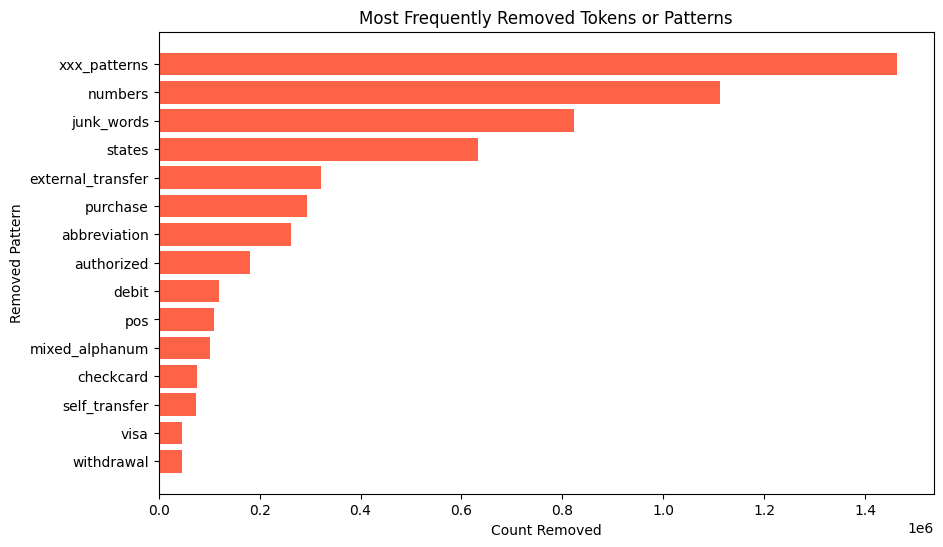

In [15]:
import matplotlib.pyplot as plt

removed_df = pd.DataFrame(removed_counter.most_common(), columns=["pattern_removed", "count"])

plt.figure(figsize=(10,6))
plt.barh(removed_df.head(15)["pattern_removed"], removed_df.head(15)["count"], color="tomato")
plt.gca().invert_yaxis()
plt.title("Most Frequently Removed Tokens or Patterns")
plt.xlabel("Count Removed")
plt.ylabel("Removed Pattern")
plt.show()


## DataFrame Cleaning

In [16]:
# remove non cleaned memo col
outflows_cleaned = outflows.drop('memo', axis=1)

# only keep essential 9 categories
essential_categories = ["EDUCATION", "FOOD_AND_BEVERAGES", "GENERAL_MERCHANDISE", "GROCERIES", "MORTGAGE", "OVERDRAFT", "PETS", "RENT", "TRAVEL"]

# convert posted_date to datetime
outflows_cleaned['posted_date'] = pd.to_datetime(outflows_cleaned['posted_date'])

outflows_cleaned = outflows_cleaned[outflows_cleaned["category"].isin(essential_categories)]
outflows_cleaned

,prism_consumer_id,prism_account_id,amount,posted_date,category,memo_clean
2,0,acc_0,18.42,2022-09-26,FOOD_AND_BEVERAGES,TST CASA DEL RIO EXP FAIRLAWN
4,0,acc_0,26.47,2022-09-12,FOOD_AND_BEVERAGES,BUFFALO WILD WINGS
6,0,acc_0,11.73,2022-04-18,GENERAL_MERCHANDISE,OCULUS
7,0,acc_0,30.04,2022-03-09,FOOD_AND_BEVERAGES,LOS GIRASOLES STOW
8,0,acc_0,4.16,2022-03-29,GENERAL_MERCHANDISE,BUZZIS LAUNDRY
...,...,...,...,...,...,...
2597457,5941,acc_9524,15.93,2023-01-16,GENERAL_MERCHANDISE,PURCHASEAMAZON PRIME AMAZON DATE PURCH
2597462,5941,acc_9524,25.00,2023-01-18,EDUCATION,WITHDRAWALAZ LOT QUIKTRIP E INDIAN SCHOOL RD P...
2597465,5941,acc_9524,3.68,2023-01-18,FOOD_AND_BEVERAGES,WITHDRAWALWAL MART E MCKELLIPS RD MESA MCC
2597468,5941,acc_9524,90.00,2023-01-20,FOOD_AND_BEVERAGES,SALT RIVER PROJETYPE ONLINE SALT RIVER PROJECT...


## Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split

unique_consumer_ids = outflows_cleaned['prism_consumer_id'].unique()
print(f'Unique Consumer IDs: {len(unique_consumer_ids)}')


Unique Consumer IDs: 2952


In [18]:

outflows_train_ids, outflows_test_ids = train_test_split(
    unique_consumer_ids,
    test_size=0.25,
    random_state=42,
)

train_df = outflows_cleaned[outflows_cleaned['prism_consumer_id'].isin(outflows_train_ids)].copy()
test_df  = outflows_cleaned[outflows_cleaned['prism_consumer_id'].isin(outflows_test_ids)].copy()

print(f'Train Shape: {train_df.shape}')
print(f'Test Shape: {test_df.shape}')

Train Shape: (969666, 6)
Test Shape: (336786, 6)


## TF/IDF Features

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)

X_train_tfidf = vectorizer.fit_transform(train_df['memo_clean'])
X_test_tfidf = vectorizer.transform(test_df['memo_clean'])

## Additional Features

### OHE For Day of the Week
Create `day_of_week` feature (0 = Monday, 6 = Sunday)

In [20]:
train_df.loc[:, 'day_of_week'] = train_df['posted_date'].dt.dayofweek
test_df.loc[:, 'day_of_week']  = test_df['posted_date'].dt.dayofweek

train_df = pd.get_dummies(train_df, columns=['day_of_week'], prefix='day', dtype=int)
test_df  = pd.get_dummies(test_df,  columns=['day_of_week'], prefix='day', dtype=int)

train_df.head()

,prism_consumer_id,prism_account_id,amount,posted_date,category,memo_clean,day_0,day_1,day_2,day_3,day_4,day_5,day_6
2,0,acc_0,18.42,2022-09-26,FOOD_AND_BEVERAGES,TST CASA DEL RIO EXP FAIRLAWN,1,0,0,0,0,0,0
4,0,acc_0,26.47,2022-09-12,FOOD_AND_BEVERAGES,BUFFALO WILD WINGS,1,0,0,0,0,0,0
6,0,acc_0,11.73,2022-04-18,GENERAL_MERCHANDISE,OCULUS,1,0,0,0,0,0,0
7,0,acc_0,30.04,2022-03-09,FOOD_AND_BEVERAGES,LOS GIRASOLES STOW,0,0,1,0,0,0,0
8,0,acc_0,4.16,2022-03-29,GENERAL_MERCHANDISE,BUZZIS LAUNDRY,0,1,0,0,0,0,0


### Is Weekend?
Create `is_weekend` feature (1 = Weekend, 0 = Weekday)

In [21]:
# assumes day_of_week already created
train_df['is_weekend'] = (train_df['posted_date'].dt.dayofweek >= 5).astype(int)
test_df['is_weekend']  = (test_df['posted_date'].dt.dayofweek  >= 5).astype(int)

train_df[['posted_date','is_weekend']].head()

,posted_date,is_weekend
2,2022-09-26,0
4,2022-09-12,0
6,2022-04-18,0
7,2022-03-09,0
8,2022-03-29,0


### Whole Dollar Amount?
Create `whole_dollar` to better distinguish if certain transactions were from an ATM or transfer payments

In [22]:
import numpy as np

train_df['is_whole_dollar'] = ((train_df['amount'] % 1) == 0).astype(int)
test_df['is_whole_dollar']  = ((test_df['amount'] % 1) == 0).astype(int)

train_df[['amount', 'is_whole_dollar']].head()

,amount,is_whole_dollar
2,18.42,0
4,26.47,0
6,11.73,0
7,30.04,0
8,4.16,0


### Month and Day
Create `month` and `day` to capture trends in seasonal spending habits or typical monthly billing cycles

In [23]:
train_df['month'] = train_df['posted_date'].dt.month
test_df['month']  = test_df['posted_date'].dt.month

train_df = pd.get_dummies(train_df, columns=['month'], prefix='month', dtype=int)
test_df  = pd.get_dummies(test_df,  columns=['month'], prefix='month', dtype=int)

train_df.head()

,prism_consumer_id,prism_account_id,amount,posted_date,category,memo_clean,day_0,day_1,day_2,day_3,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2,0,acc_0,18.42,2022-09-26,FOOD_AND_BEVERAGES,TST CASA DEL RIO EXP FAIRLAWN,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,acc_0,26.47,2022-09-12,FOOD_AND_BEVERAGES,BUFFALO WILD WINGS,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,acc_0,11.73,2022-04-18,GENERAL_MERCHANDISE,OCULUS,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,0,acc_0,30.04,2022-03-09,FOOD_AND_BEVERAGES,LOS GIRASOLES STOW,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
8,0,acc_0,4.16,2022-03-29,GENERAL_MERCHANDISE,BUZZIS LAUNDRY,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


### Log Amount
Create `amount_log` to account for the skewed dollar amounts

In [24]:
train_df['amount_log'] = np.log1p(train_df['amount'])
test_df['amount_log']  = np.log1p(test_df['amount'])

train_df[['amount', 'amount_log']].head()

,amount,amount_log
2,18.42,2.966303
4,26.47,3.313095
6,11.73,2.543961
7,30.04,3.435277
8,4.16,1.640937


### Combine Features
Combine both TF/IDF and Date/Amount features into a unified dataframe.

In [25]:
from scipy.sparse import hstack, csr_matrix

# extract target features
y_train = train_df['category'].to_numpy()
y_test  = test_df['category'].to_numpy()

# combine features while dropping category
train_df = train_df.drop(columns=['category'])
test_df  = test_df.drop(columns=['category'])

num_cols = [
    'day_0','day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'is_weekend', 'is_whole_dollar','amount_log'
]
X_train_num = csr_matrix(train_df[num_cols].to_numpy(dtype=np.float32))
X_test_num  = csr_matrix(test_df[num_cols].to_numpy(dtype=np.float32))

X_train = hstack([X_train_tfidf, X_train_num], format='csr')
X_test  = hstack([X_test_tfidf,  X_test_num],  format='csr')

In [26]:
# Day-of-week one-hot should have exactly one 1 per row
assert ((train_df[[f'day_{i}' for i in range(7)]].sum(axis=1) == 1).all())

# Same month columns present
mcols = [f'month_{i}' for i in range(1,13)]
assert set(mcols).issubset(set(train_df.columns)) and set(mcols).issubset(set(test_df.columns))

# Shapes line up
print(X_train_tfidf.shape, X_test_tfidf.shape)


(969666, 5000) (336786, 5000)
